In [1]:
# Imports
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import Lasso, LassoCV
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Import the JgKMeans class
from jg_ml_models import JgKMeans, ModelPreprocessor

## Inspect the data

In [3]:
# Load data
train_full_df = pd.read_csv('../data/train.csv').drop('Id', axis=1)
train_full_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
train_full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

## Prepare the data for feature selection

In [5]:
# Initialize the JgKMeans class with the original market data
target_col = 'SalePrice'
pre_proc = ModelPreprocessor(train_full_df, target_col=target_col)

# Variables specific to this dataset
numeric_cols: list[str] = pre_proc.get_numeric_columns()
encode_cols: list[str] = pre_proc.get_columns_to_encode()
top_feature_cols: list[str] = []

# Scale the numeric columns and put results into a new DataFrame
scaled_train_df = pre_proc.scale_numeric_columns()
scaled_train_df.head()


,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,0.073375,-0.208034,-0.207142,0.651479,-0.517200,1.050994,0.878668,0.510015,0.575425,-0.288653,...,-0.752176,0.216503,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,-1.599111,0.138777,0.347273
1,-0.872563,0.409895,-0.091886,-0.071836,2.179628,0.156734,-0.429577,-0.572835,1.171992,-0.288653,...,1.626195,-0.704483,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,-0.489110,-0.614439,0.007288
2,0.073375,-0.084449,0.073480,0.651479,-0.517200,0.984752,0.830215,0.322174,0.092907,-0.288653,...,-0.752176,-0.070361,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,0.990891,0.138777,0.536154
3,0.309859,-0.414011,-0.096897,0.651479,-0.517200,-1.863632,-0.720298,-0.572835,-0.499274,-0.288653,...,-0.752176,-0.176048,4.092524,-0.116339,-0.270208,-0.068692,-0.087688,-1.599111,-1.367655,-0.515281
4,0.073375,0.574676,0.375148,1.374795,-0.517200,0.951632,0.733308,1.360826,0.463568,-0.288653,...,0.780197,0.563760,-0.359325,-0.116339,-0.270208,-0.068692,-0.087688,2.100892,0.138777,0.869843


### Create a correlation, coefficient, and pval matrix of the numeric colums compared to the target column

In [6]:
combo_df = pre_proc.get_combined_important_numeric_features_df(scaled_df=scaled_train_df)
combo_df.head()

Best alpha: 100.0 (R^2 score:  0.81)


,correlation,coefficient,pval,total
OverallQual,0.790982,1.000000,0.000000,1.790982
GarageArea,0.623431,0.156094,0.737933,1.517458
LotFrontage,0.351799,0.071237,0.847097,1.270134
HalfBath,0.284108,0.039925,0.926857,1.250889
GarageYrBlt,0.486362,0.021444,0.725255,1.233060


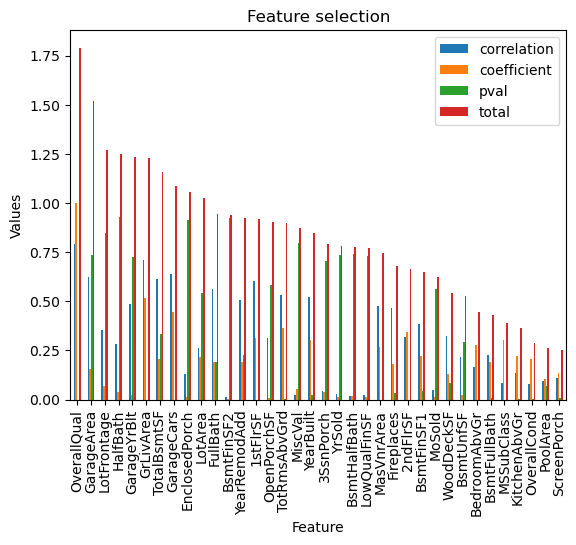

In [7]:
pre_proc.plot_feature_selection(combo_df)


In [8]:
# Get the top correlated numeric features
top_corr_numeric_features = pre_proc.get_top_total_numeric_features_list(scaled_df=scaled_train_df, total_min=0.8)
top_corr_numeric_features

Best alpha: 100.0 (R^2 score:  0.81)


['OverallQual',
 'GarageArea',
 'LotFrontage',
 'HalfBath',
 'GarageYrBlt',
 'GrLivArea',
 'TotalBsmtSF',
 'GarageCars',
 'EnclosedPorch',
 'LotArea',
 'FullBath',
 'BsmtFinSF2',
 'YearRemodAdd',
 '1stFlrSF',
 'OpenPorchSF',
 'TotRmsAbvGrd',
 'MiscVal',
 'YearBuilt']

## Encode the colums containing string data

In [9]:
# Set up the OneHotEncoder so it will transform to Pandas
# Fit and transform the OneHotEncoder to the columns to encode
encoded_train_df = pre_proc.encode_string_columns_ohe(encode_cols=encode_cols, target_col=target_col)
encoded_train_df.head()

,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_Pave,Alley_nan,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SalePrice
0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,208500
1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,181500
2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,223500
3,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,140000
4,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,250000


### Create a correlation matrix of the encoded colums compared to the target column

In [10]:
correlation_matrix_abs_df = pre_proc.get_pd_corr_abs_encoded_features_df(encoded_df=encoded_train_df)
correlation_matrix_abs_df.head()

,correlation
ExterQual_TA,0.589044
BsmtQual_Ex,0.553105
KitchenQual_TA,0.519298
KitchenQual_Ex,0.504094
Foundation_PConc,0.497734


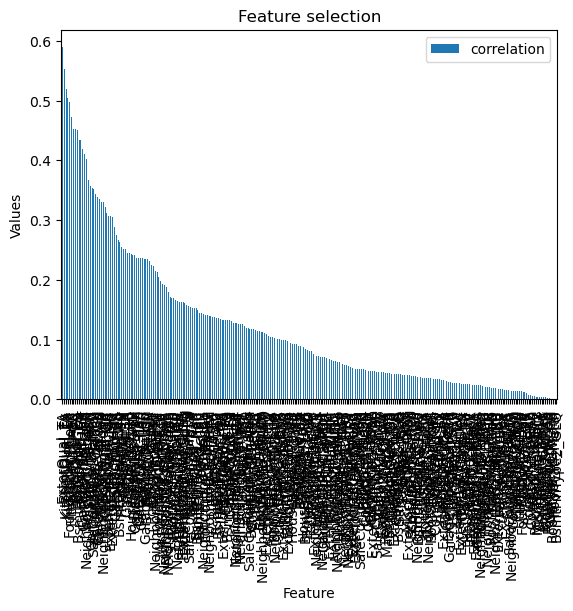

In [11]:
pre_proc.plot_feature_selection(correlation_matrix_abs_df)

In [17]:
# Get the top correlated encoded features
top_corr_encoded_features = pre_proc.get_top_corr_abs_encoded_features_list(encoded_df=encoded_train_df, corr_min=0.35)
top_corr_encoded_features

['BsmtFinType1',
 'SaleType',
 'BsmtQual',
 'Neighborhood',
 'MasVnrType',
 'FireplaceQu',
 'KitchenQual',
 'GarageFinish',
 'ExterQual',
 'GarageType',
 'SaleCondition',
 'Foundation',
 'HeatingQC']

In [18]:
# Get all of the top numeric and encoded features in one step
top_feature_cols = pre_proc.get_top_feature_cols(scaled_df=scaled_train_df, total_min=0.8, encoded_df=encoded_train_df, corr_min=0.35)


Best alpha: 100.0 (R^2 score:  0.81)


In [19]:
simplified_col_list = top_feature_cols + [target_col]
simplified_col_list

['OverallQual',
 'GarageArea',
 'LotFrontage',
 'HalfBath',
 'GarageYrBlt',
 'GrLivArea',
 'TotalBsmtSF',
 'GarageCars',
 'EnclosedPorch',
 'LotArea',
 'FullBath',
 'BsmtFinSF2',
 'YearRemodAdd',
 '1stFlrSF',
 'OpenPorchSF',
 'TotRmsAbvGrd',
 'MiscVal',
 'YearBuilt',
 'BsmtFinType1',
 'SaleType',
 'BsmtQual',
 'Neighborhood',
 'MasVnrType',
 'FireplaceQu',
 'KitchenQual',
 'GarageFinish',
 'ExterQual',
 'GarageType',
 'SaleCondition',
 'Foundation',
 'HeatingQC',
 'SalePrice']

## Need to do VIF and PCA testing here

In [ ]:
# Do VIF testing to further refine the top_feature_cols